<a href="https://colab.research.google.com/github/JGRimst/ML/blob/Assignment_2/chinese_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import regularizers

from tensorflow.keras import Sequential

from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.deterministic import Seasonality, DeterministicProcess, TimeTrend
from statsmodels.tsa.vector_ar import var_model
from sklearn.model_selection import train_test_split
from scipy.signal import correlate

%load_ext autoreload
%autoreload 2

In [101]:
# prompt: call in the data and then take the first differences

import pandas as pd
# Assuming your data is in a CSV file named 'your_data.csv'
# Replace 'your_data.csv' with the actual file name
df = pd.read_csv('ETTh1.csv', index_col=0, parse_dates=True)

# Calculate the first difference of your data
# df_diff = df.diff().dropna()
df.columns


Index(['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'], dtype='object')

In [3]:
# # prompt: plot HULL MUFL LUFL and LULL on different plots

# import matplotlib.pyplot as plt
# plt.figure(figsize=(12, 8))

# plt.subplot(2, 2, 1)
# plt.plot(data['HULL'])
# plt.title('HULL')

# plt.subplot(2, 2, 2)
# plt.plot(data['MUFL'])
# plt.title('MUFL')

# plt.subplot(2, 2, 3)
# plt.plot(data['LUFL'])
# plt.title('OT')

# plt.subplot(2, 2, 4)
# plt.plot(data['LULL'].diff().dropna())
# plt.title('LUFL')

# plt.tight_layout()
# plt.show()


In [102]:
window_size = 18
features_size = 5
input_shape = (window_size, features_size)

output_size = 1

In [97]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

target_column = 'OT'

# Define the split ratios
train_ratio = 0.8
test_ratio = 0.20

# Calculate the split indices
data_length = len(df)
train_size = int(data_length * train_ratio)
test_size = data_length - train_size

X = df.drop(columns=['OT']).values
y = df[target_column].values

# Split the data into train, validation, and test sets
X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

def split_multivar_sequences(sequenceX, sequenceY, n_steps):
    X, y = list(), list()
    for i in range(len(sequenceX)):
        # find the end of this pattern
        end_idx = i + n_steps
        # check if we are beyond the dataset
        if end_idx > len(sequenceY)-1:
            break
        # Gather input (sequenceX) and past sequenceY values
        seq_x = sequenceX[i:end_idx, :]  # Inputs: n_steps sequence from sequenceX
        seq_y_past = sequenceY[i:end_idx].reshape(-1, 1)  # Past Y values in the same window (reshape to match sequenceX)

        # Combine the past values of Y with X to form the input
        combined_seq = np.hstack((seq_x, seq_y_past))  # Horizontally stack the sequenceX and past Y

        # Output is the future value of Y (next step after the window)
        next_y = sequenceY[end_idx]

        # X.append(seq_x)
        X.append(combined_seq)
        y.append(next_y)

    return np.array(X), np.array(y)


X_train, y_train = split_multivar_sequences(X_train,y_train, window_size)
X_test, y_test = split_multivar_sequences(X_test,y_test, window_size)
# # prompt: split the time series data into train, valid and test sets where future values of OT are being estimated
# # train_df_X = scaler.fit_transform(train_df.drop(columns=['OT']).values)

# # Assuming your target variable is 'OT'
# target_column = 'OT'

# # Define the split ratios
# train_ratio = 0.8
# test_ratio = 0.20

# # Calculate the split indices
# data_length = len(df)
# train_size = int(data_length * train_ratio)
# test_size = data_length - train_size

# # Split the data into train, validation, and test sets
# X_train = X[:train_size]
# y_train = y[:train_size]

# X_test = X[train_size:]
# y_test = y[train_size:]
y_train.shape


(13918,)

In [6]:
# prompt: add random noise to the output

import numpy as np
noise_level = 0.05  # Adjust this value to control the amount of noise

# Add random noise to y_train
y_train = y_train + np.random.normal(0, noise_level, size=y_train.shape)


In [7]:
!pip install keras-tuner -q

batch_size = 32
from keras_tuner import RandomSearch

units = 32
def build_simple(input_shape):
  # # Create a simple RNN that follows the same structure as the custom RNN cell
  simple_rnn = layers.SimpleRNN(units, return_sequences=False)  # Output shape will now be (batch_size, 32)

  # Input layer
  inputs = layers.Input(shape=input_shape)  # 24 time steps, 1 feature per step
  x = layers.BatchNormalization()(inputs)
  # RNN layer
  x = simple_rnn(x)  # Only the last output is returned, shape will be (batch_size, 32)

  x = layers.Activation('tanh')(x)
  x = layers.Dropout(0.2)(x)


  output = layers.Dense(1)(x)  # Output shape will be (batch_size, 1)

  # Build the model
  model = models.Model(inputs, output)

  early_stopping = keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=10, restore_best_weights=True)
  model.compile(optimizer= keras.optimizers.Adam(0.005), loss=tf.keras.losses.Huber(delta=1.0), metrics=['mean_absolute_error', tf.keras.losses.Huber(delta=1.0)])
  return model, early_stopping
# def build_model(hp):
#     model = tf.keras.Sequential()
#     model.add(layers.SimpleRNN(
#         units=hp.Int('units', min_value=8, max_value=128, step=16),
#         activation='relu',
#         input_shape=(X_train.shape[1], X_train.shape[2])
#     ))
#     model.add(layers.Dropout(hp.Float('dropout', 0, 0.5, step=0.1)))
#     model.add(layers.Dense(1))

#     model.compile(optimizer=tf.keras.optimizers.Adam(
#         hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
#         loss=['mean_absolute_error'], metrics=['mean_absolute_error'])

#     return model
simple_model, early_stopping = build_simple(input_shape)
hist = simple_model.fit(x=X_train,y=y_train, validation_split = 0.1 ,epochs=100,callbacks=[early_stopping], shuffle=False)
# early_stopping = keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=5, restore_best_weights=True, mode='min',)
# tuner = RandomSearch(build_model,
#                     objective='val_mean_absolute_error',
#                     max_trials=5,
#                     executions_per_trial=3)

# tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping], shuffle=False)
# best_model = tuner.get_best_models(num_models=1)[0]
# best_model.summary()

Epoch 1/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - huber_loss: 14.6041 - loss: 14.6041 - mean_absolute_error: 15.0924 - val_huber_loss: 3.1530 - val_loss: 3.1472 - val_mean_absolute_error: 3.6193
Epoch 2/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - huber_loss: 11.9156 - loss: 11.9156 - mean_absolute_error: 12.4026 - val_huber_loss: 4.0246 - val_loss: 4.0228 - val_mean_absolute_error: 4.5182
Epoch 3/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - huber_loss: 11.5564 - loss: 11.5564 - mean_absolute_error: 12.0440 - val_huber_loss: 4.1210 - val_loss: 4.1259 - val_mean_absolute_error: 4.6227
Epoch 4/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - huber_loss: 11.3249 - loss: 11.3249 - mean_absolute_error: 11.8130 - val_huber_loss: 7.0522 - val_loss: 7.0383 - val_mean_absolute_error: 7.5350
Epoch 5/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - huber_loss: 12.4699 - loss: 12.4699 - mean_absolute_error: 12.9561 - val_huber_loss: 2.2642 - val_loss: 2.2647 - val_mean_absolute_error: 2.7443

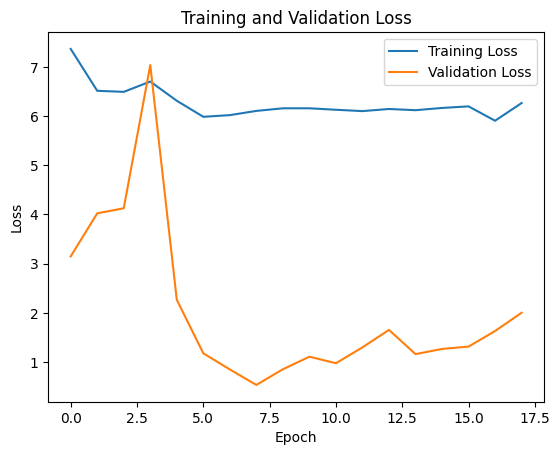

In [8]:
# prompt: plot the validation loss vs the training loss

import matplotlib.pyplot as plt
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


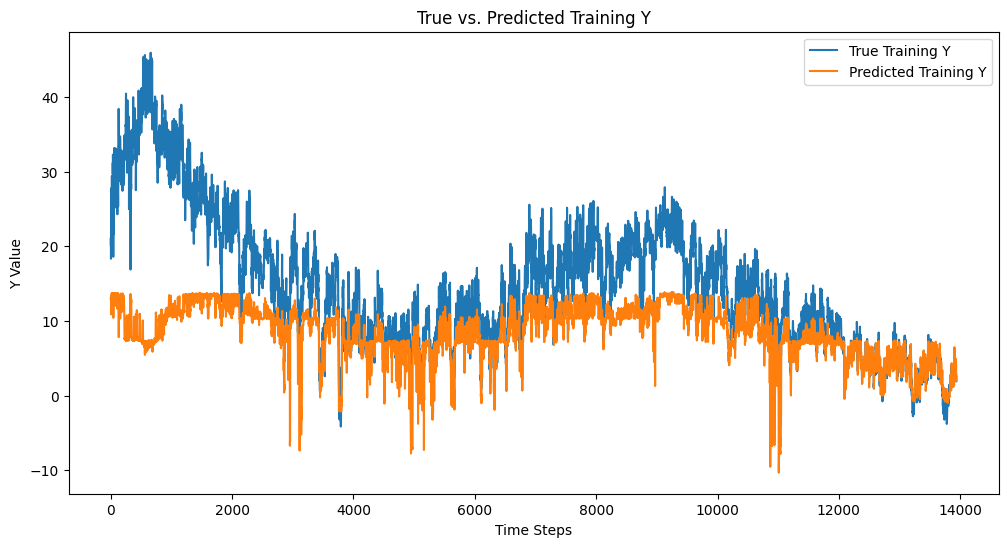

In [9]:
# prompt: plot the true training y as well as the predicted training y

import matplotlib.pyplot as plt
y_train_pred = simple_model.predict(X_train)

plt.figure(figsize=(12, 6))
plt.plot(y_train, label='True Training Y')
plt.plot(y_train_pred, label='Predicted Training Y')
plt.title('True vs. Predicted Training Y')
plt.xlabel('Time Steps')
plt.ylabel('Y Value')
plt.legend()
plt.show()


108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


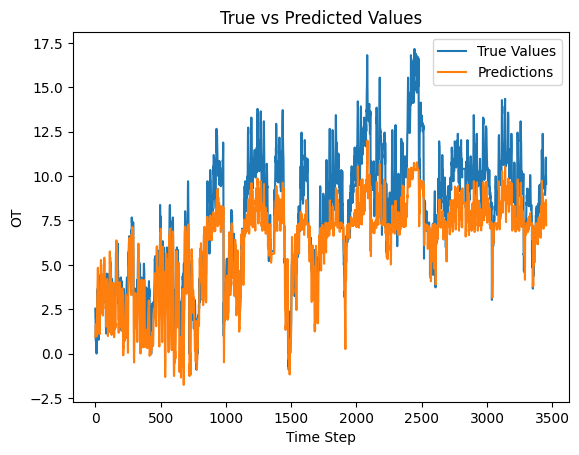

In [10]:
# prompt: plot the true y vs the predicted y

import matplotlib.pyplot as plt
predictions = simple_model.predict(X_test)

# Assuming your test_y is a NumPy array or a list
plt.plot(y_test, label='True Values')
plt.plot(predictions, label='Predictions')
plt.title('True vs Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('OT')
plt.legend()
plt.show()


In [11]:
# prompt: give me the mse for the test data

mse = simple_model.evaluate(X_test, y_test)[1]
print(f"MSE on test data: {mse}")


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - huber_loss: 1.1211 - loss: 1.1211 - mean_absolute_error: 1.5546
MSE on test data: 1.8558375835418701


In [12]:


# Define a custom RNN cell (e.g., Jordan RNN)
class JordanRNNCell(layers.Layer):
    def __init__(self, units, output_size, activation, **kwargs):
        super(JordanRNNCell, self).__init__(**kwargs)
        self.units = units
        self.output_size = output_size
        self.activation = activation

    @property
    def state_size(self):
        return self.output_size

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W_xh = self.add_weight(shape=(input_dim, self.units), name='W_xh')
        self.W_oh = self.add_weight(shape=(self.output_size, self.units), name='W_oh')
        self.b_h = self.add_weight(shape=(self.units,), name='b_h')
        self.W_hy = self.add_weight(shape=(self.units, self.output_size), name='W_hy')
        self.b_y = self.add_weight(shape=(self.output_size,), name='b_y')

    def call(self, inputs, states):
        prev_output = states[0]

        h = tf.matmul(inputs, self.W_xh) + tf.matmul(prev_output, self.W_oh) + self.b_h
        h = self.activation(h)
        y = tf.matmul(h, self.W_hy) + self.b_y
        return y, [y]

class MRNNcell(layers.Layer):
  def __init__(self, units, output_size, activation, **kwargs):
      super(MRNNcell, self).__init__(**kwargs)
      self.units = units
      self.output_size = output_size
      self.activation = activation

  @property
  def state_size(self):
      return [self.units, self.output_size]

  def build(self, input_shape):
      input_dim = input_shape[-1]
      ##Jordan ## outputs of previous time step
      self.W_oh = self.add_weight(shape=(self.output_size, self.units), name='W_oh')

      ## Elman ## feedback from hidden units after activation
      self.W_feedback = self.add_weight(shape=(self.units, self.units), name='W_feedback')

      ## Normal weights and biases
      self.b_h = self.add_weight(shape=(self.units,), name='b_h')
      self.b_y = self.add_weight(shape=(self.output_size,), name='b_y')

      self.W_xh = self.add_weight(shape=(input_dim, self.units), name='W_xh')
      self.W_hy = self.add_weight(shape=(self.units, self.output_size), name='W_hy')



  def call(self, inputs, states):
    if len(states) != 2:
    # Initialize states if they are not provided
      prev_state = states[0]
      prev_output = tf.zeros((1, self.output_size))
    else:
      prev_state = states[0]  # previous hidden state
      prev_output = states[1]  # previous output

    prev_state = states[0]  # previous hidden state (activation)
    prev_output = states[1]  # previous output

    state = tf.matmul(inputs, self.W_xh) + tf.matmul(prev_state, self.W_feedback) + self.b_h

    output_feedback = tf.matmul(prev_output, self.W_oh)
    next_state = self.activation(state + output_feedback)

    # Compute the next output (usually based on the next state or some transformation of it)
    next_output = tf.matmul(next_state, self.W_hy) + self.b_y

    # Return the next state (hidden state) and the output
    return next_output, [next_state, next_output]



In [28]:
# prompt: turn X_train into a flattened array and then scale the array

# X_train_flattened = X_train.reshape(-1, X_train.shape[-1])
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train_flattened).reshape(X_train.shape)
# X_test = scaler.transform(X_test.reshape(-1, X_train.shape[-1])).reshape(X_test.shape)

# y_train = scaler.fit_transform(y_train.reshape(-1, 1)).reshape(-1)


In [41]:
# Wrap the custom cell in an RNN layer
custom_cell = JordanRNNCell(units=units, output_size=output_size, activation=tf.nn.tanh)
rnn_layer = layers.RNN(custom_cell, return_sequences=True, return_state=True)

# Build the model
inputs = layers.Input(input_shape)  # (time_steps, input_dim)
inputs = layers.BatchNormalization()(inputs)
outputs, final_state = rnn_layer(inputs)
outputs = layers.Dropout(0.2)(outputs)

predictions = layers.Dense(output_size)(final_state)

jordan_RNN = models.Model(inputs, predictions)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)

jordan_RNN.compile(optimizer='adam', loss='mae', metrics=['mae'])
# jordan_RNN.summary()

jordan_RNN.summary()
hist = jordan_RNN.fit(x=X_train,y=y_train, validation_split = 0.3 ,epochs=100,callbacks=[early_stopping], shuffle=False)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ keras_tensor_47CLONE (InputLayer)    │ (None, 30, 7)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rnn_10 (RNN)                         │ [(None, 30, 1), (None, 1)]  │             321 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 30, 1)               │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 321 (1.25 KB)

 Trainable params: 321 (1.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 19.6705 - mae: 19.6705 - val_loss: 4.1605 - val_mae: 4.1605
Epoch 2/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 12.5539 - mae: 12.5539 - val_loss: 4.3425 - val_mae: 4.3425
Epoch 3/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 10.4447 - mae: 10.4447 - val_loss: 3.9860 - val_mae: 3.9860
Epoch 4/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 9.5460 - mae: 9.5460 - val_loss: 3.8602 - val_mae: 3.8602
Epoch 5/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 8.9690 - mae: 8.9690 - val_loss: 3.9423 - val_mae: 3.9423
Epoch 6/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 8.7463 - mae: 8.7463 - val_loss: 3.9579 - val_mae: 3.9579
Epoch 7/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 8.5362 - mae: 8.5362 - val_loss: 3.9608 - val_mae: 3.9608
Epoch 8/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 8.6160 - mae: 8.6160 - val_loss: 4.1034 - val_mae: 4.1034
Epoch 9/100
305/305 ━━━━━━━━━━━━━━━━━━━━

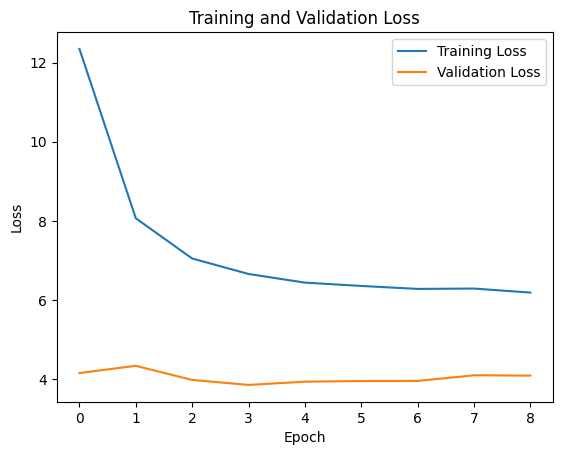

435/435 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


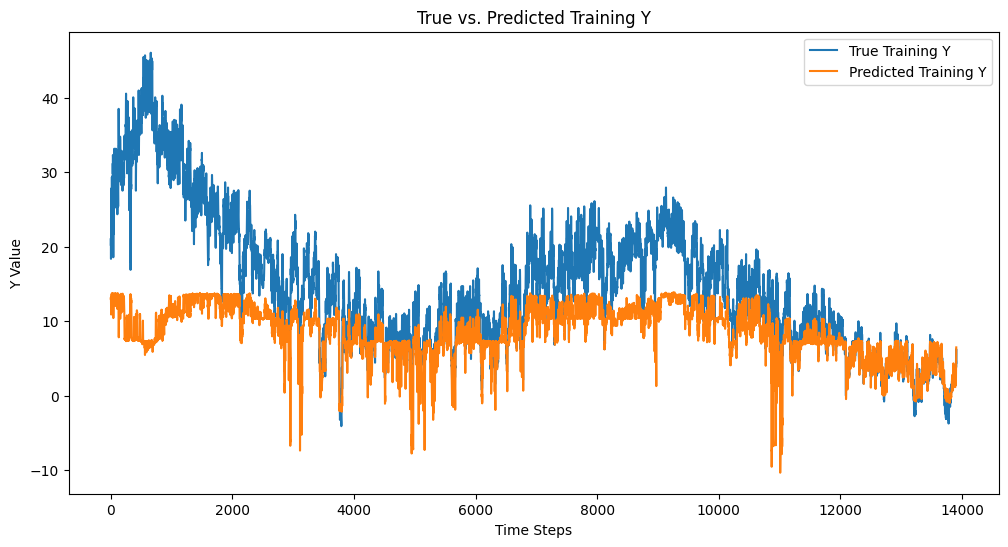

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


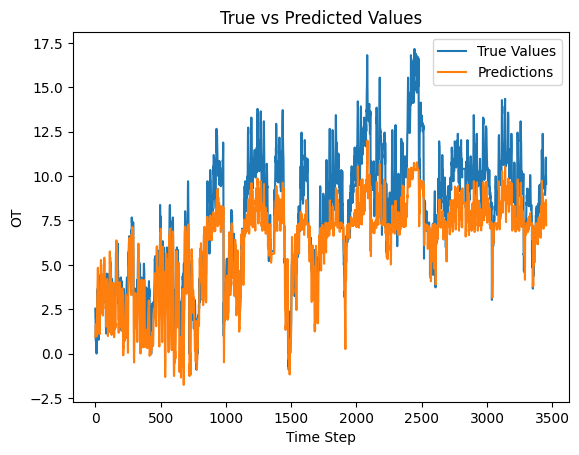

In [42]:
# prompt: plot the true training y as well as the predicted training y
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
y_train_pred = simple_model.predict(X_train)

plt.figure(figsize=(12, 6))
plt.plot(y_train, label='True Training Y')
plt.plot(y_train_pred, label='Predicted Training Y')
plt.title('True vs. Predicted Training Y')
plt.xlabel('Time Steps')
plt.ylabel('Y Value')
plt.legend()
plt.show()

predictions = simple_model.predict(X_test)
# predictions = scaler.inverse_transform(predictions)
# Assuming your test_y is a NumPy array or a list
plt.plot(y_test, label='True Values')
plt.plot(predictions, label='Predictions')
plt.title('True vs Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('OT')
plt.legend()
plt.show()


In [47]:

def build_model(hp):
    # Hyperparameters
    units = hp.Int('units', min_value=8, max_value=128, step=16)
    dropout_rate = hp.Float('dropout_rate', 0.1, 0.5, step=0.1)
    activation_function = hp.Choice('activation_function', ['tanh', 'relu'])
    # Define your custom RNN cell

    if activation_function == 'tanh':
        activation = tf.nn.tanh
    else:
        activation = tf.nn.relu

    custom_cell = JordanRNNCell(units=units, output_size=output_size, activation=activation)

    # Wrap the custom cell in an RNN layer with dropout
    rnn_layer = layers.RNN(custom_cell, return_sequences=True, return_state=True,
                           )

    # Build the model
    inputs = layers.Input(shape=input_shape)  # (time_steps, input_dim)
    inputs = layers.BatchNormalization()(inputs)

    # Pass inputs through the RNN layer
    outputs, final_state = rnn_layer(inputs)
    outputs = layers.Dropout(dropout_rate)(outputs)

    # Predictions based on the final state
    predictions = layers.Dense(output_size)(final_state)

    # Create the model
    model = models.Model(inputs, predictions)

    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='mae', metrics=['mae'])

    return model

# Set up Keras Tuner
tuner = RandomSearch(build_model,
                     objective='val_mae',
                     max_trials=10,
                     executions_per_trial=3,
                     directory='my_dir',  # Directory to save the results
                     project_name='jordan_rnn_tuning')

# Early stopping callback
early_stopping =  keras.callbacks.EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)

# Perform hyperparameter tuning
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

# Optionally, you can evaluate the best model on the test set
test_loss, test_mae = best_model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae}")

Trial 10 Complete [00h 03m 34s]
val_mae: 2.164267659187317

Best val_mae So Far: 0.48752252260843915
Total elapsed time: 00h 35m 28s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ keras_tensor_1CLONE (InputLayer)     │ (None, 30, 7)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rnn (RNN)                            │ [(None, 30, 1), (None, 1)]  │              81 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 83 (332.00 B)

 Trainable params: 83 (332.00 B)

 Non-trainable params: 0 (0.00 B)

108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5019 - mae: 0.5019
Test MAE: 0.4681800901889801


Epoch 1/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.6973 - mae: 0.6973 - val_loss: 0.4549 - val_mae: 0.4549
Epoch 2/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.7018 - mae: 0.7018 - val_loss: 0.4902 - val_mae: 0.4902
Epoch 3/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.6992 - mae: 0.6992 - val_loss: 0.4715 - val_mae: 0.4715
Epoch 4/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.7139 - mae: 0.7139 - val_loss: 0.4624 - val_mae: 0.4624
Epoch 5/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.6971 - mae: 0.6971 - val_loss: 0.5146 - val_mae: 0.5146
Epoch 6/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.7179 - mae: 0.7179 - val_loss: 0.4732 - val_mae: 0.4732
Best units: 8
Best dropout_rate: 0.2
Best activation_function: relu
Best learning_rate: 0.001


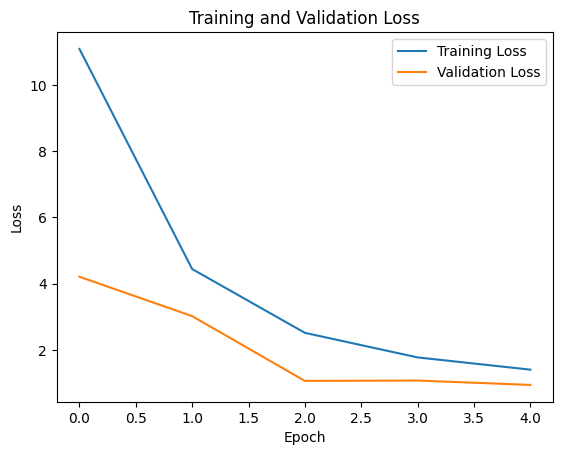

435/435 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


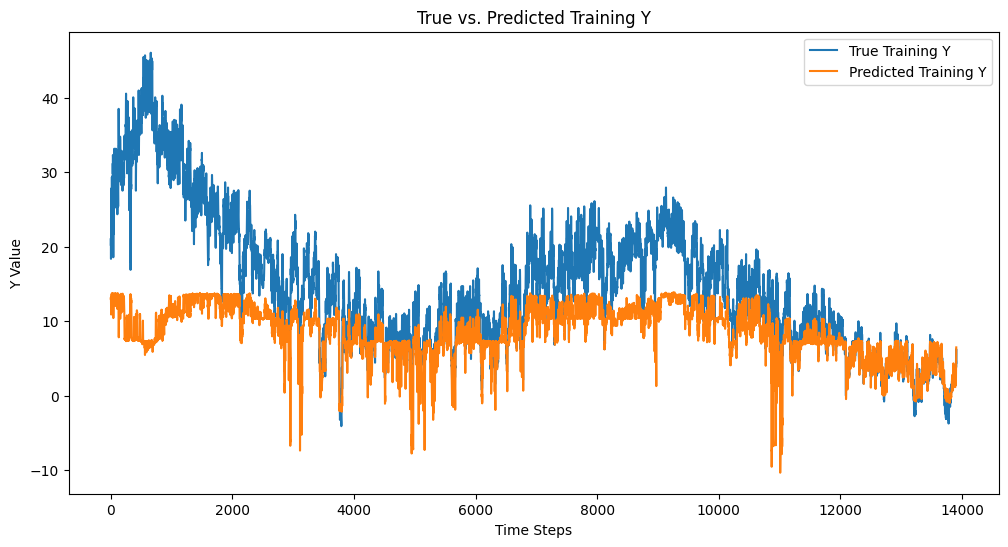

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


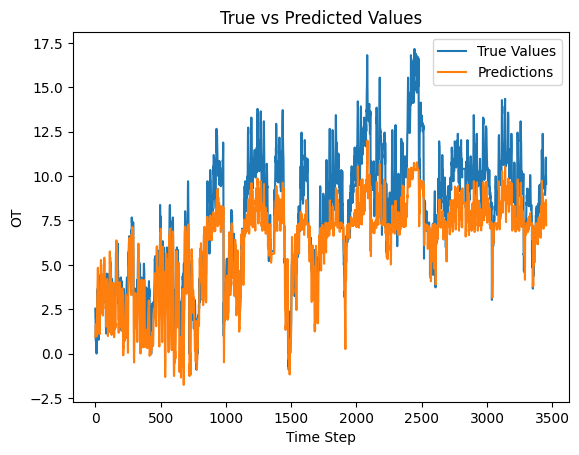

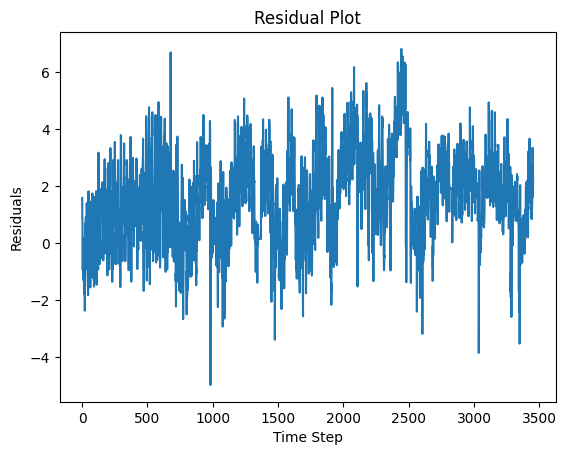

In [76]:
# prompt: Print the hyperpara,etersof the best model
# model = build_model(8)

history = best_model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best units: {best_hps.get('units')}")
print(f"Best dropout_rate: {best_hps.get('dropout_rate')}")
print(f"Best activation_function: {best_hps.get('activation_function')}")
print(f"Best learning_rate: {best_hps.get('learning_rate')}")


# prompt: plot the true training y as well as the predicted training y
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
y_train_pred = simple_model.predict(X_train)

plt.figure(figsize=(12, 6))
plt.plot(y_train, label='True Training Y')
plt.plot(y_train_pred, label='Predicted Training Y')
plt.title('True vs. Predicted Training Y')
plt.xlabel('Time Steps')
plt.ylabel('Y Value')
plt.legend()
plt.show()

predictions = simple_model.predict(X_test)
# predictions = scaler.inverse_transform(predictions)
# Assuming your test_y is a NumPy array or a list
plt.plot(y_test, label='True Values')
plt.plot(predictions, label='Predictions')
plt.title('True vs Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('OT')
plt.legend()
plt.show()

residuals = y_test.flatten() - predictions.flatten()
plt.plot(residuals)
plt.title('Residual Plot')
plt.xlabel('Time Step')
plt.ylabel('Residuals')
plt.show()

In [70]:
# prompt: evaluate the model

# Evaluate the model on the test data
loss, mae = best_model.evaluate(X_test, y_test)

print(f"Test Loss: {loss}")
print(f"Test MAE: {mae}")


108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4925 - mae: 0.4925
Test Loss: 0.4576900899410248
Test MAE: 0.4576900899410248


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ keras_tensor_99CLONE (InputLayer)    │ (None, 18, 5)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rnn_24 (RNN)                         │ [(None, 1), (None, 128),    │          17,409 │
│                                      │ (None, 1)]                  │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,411 (68.01 KB)

 Trainable params: 17,411 (68.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 7.1191 - mae: 7.1191 - val_loss: 1.4140 - val_mae: 1.4140
Epoch 2/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 4.9856 - mae: 4.9856 - val_loss: 1.3977 - val_mae: 1.3977
Epoch 3/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 5.0723 - mae: 5.0723 - val_loss: 1.5116 - val_mae: 1.5116
Epoch 4/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 5.0717 - mae: 5.0717 - val_loss: 1.4266 - val_mae: 1.4266
Epoch 5/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 5.1936 - mae: 5.1936 - val_loss: 1.3283 - val_mae: 1.3283
Epoch 6/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 4.9753 - mae: 4.9753 - val_loss: 1.3841 - val_mae: 1.3841
Epoch 7/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 4.8733 - mae: 4.8733 - val_loss: 1.3213 - val_mae: 1.3213
Epoch 8/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 5.2104 - mae: 5.2104 - val_loss: 1.3877 - val_mae: 1.3877
Epoch 9/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 6

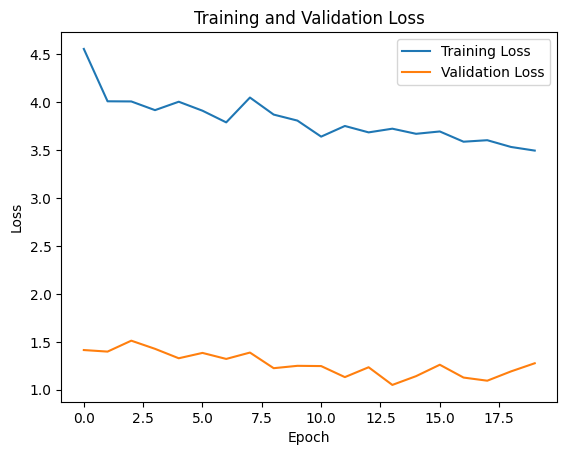

435/435 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


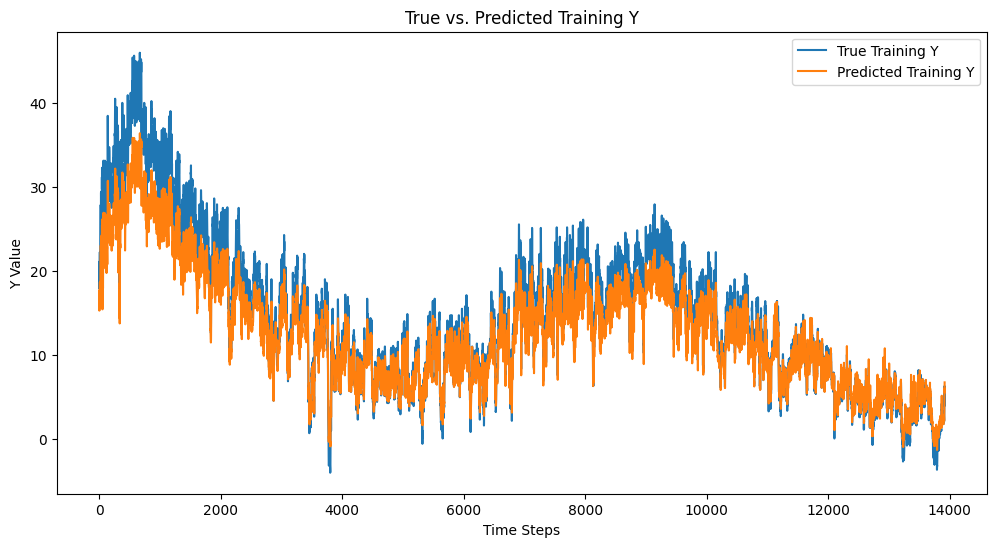

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


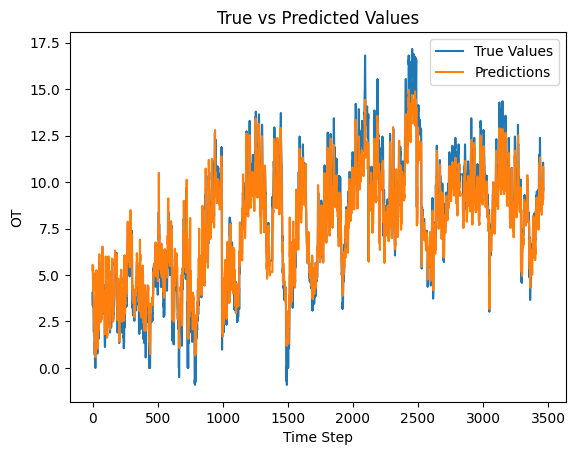

In [100]:
activation = tf.nn.relu

custom_cell = MRNNcell(units=128, output_size=output_size, activation=activation)
rnn_layer = layers.RNN(custom_cell, return_state=True)

# Build the model
inputs = layers.Input(shape=input_shape)  # Only take (time_steps, features)
inputs = layers.BatchNormalization()(inputs)
outputs, U, u = rnn_layer(inputs)

outputs = layers.Dropout(0.2)(outputs)

# Final dense layer for predictions
predictions = layers.Dense(output_size)(outputs)  # Use the hidden state for final output

# Create the model
model = models.Model(inputs, predictions)

# Compile the model
model.compile(optimizer='adam', loss='mae', metrics=['mae'])

# Summary of the model
model.summary()
early_stopping =  keras.callbacks.EarlyStopping(monitor='val_mae', patience=6, restore_best_weights=True)

hist = model.fit(x=X_train,y=y_train, validation_split = 0.3 ,epochs=100,callbacks=[early_stopping], shuffle=False)


# prompt: plot the true training y as well as the predicted training y
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
y_train_pred = model.predict(X_train)

plt.figure(figsize=(12, 6))
plt.plot(y_train, label='True Training Y')
plt.plot(y_train_pred, label='Predicted Training Y')
plt.title('True vs. Predicted Training Y')
plt.xlabel('Time Steps')
plt.ylabel('Y Value')
plt.legend()
plt.show()

predictions = model.predict(X_test)
# predictions = scaler.inverse_transform(predictions)
# Assuming your test_y is a NumPy array or a list
plt.plot(y_test, label='True Values')
plt.plot(predictions, label='Predictions')
plt.title('True vs Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('OT')
plt.legend()
plt.show()



In [99]:
y_train_pred = simple_model.predict(X_train)

plt.figure(figsize=(12, 6))
plt.plot(y_train, label='True Training Y')
plt.plot(y_train_pred, label='Predicted Training Y')
plt.title('True vs. Predicted Training Y')
plt.xlabel('Time Steps')
plt.ylabel('Y Value')
plt.legend()
plt.show()

predictions = model.predict(X_test)
# predictions = scaler.inverse_transform(predictions)
# Assuming your test_y is a NumPy array or a list
plt.plot(y_test, label='True Values')
plt.plot(predictions, label='Predictions')
plt.title('True vs Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('OT')
plt.legend()
plt.show()

InvalidArgumentError: Graph execution error:

Detected at node functional_1/batch_normalization_1/batchnorm/mul_1 defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-98-5c94064d6ada>", line 38, in <cell line: 38>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 508, in predict

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 208, in one_step_on_data_distributed

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 198, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 96, in predict_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 882, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 175, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 556, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 882, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/normalization/batch_normalization.py", line 260, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py", line 1808, in batch_normalization

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 771, in batch_normalization

Incompatible shapes: [32,18,5] vs. [7]
	 [[{{node functional_1/batch_normalization_1/batchnorm/mul_1}}]] [Op:__inference_one_step_on_data_distributed_1649671]

validation is lower because dropout is not considered in validation loss but is for training loss

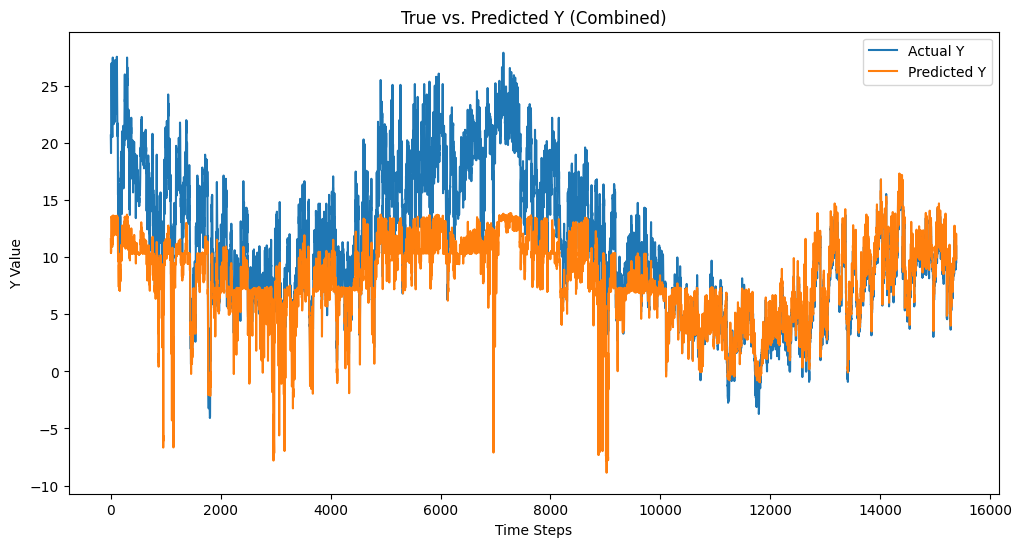

In [91]:
# prompt: put the train and test y predictions together and then compare them to all y

import numpy as np
import matplotlib.pyplot as plt

# Assuming you have y_train_pred and y_test_pred from your model's predictions
# Concatenate the predictions for train and test sets
all_y_pred = np.concatenate((y_train_pred, predictions), axis=0)

# Concatenate the actual y values for train and test sets
all_y = np.concatenate((y_train, y_test), axis=0)

# Create a plot comparing the actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(all_y, label='Actual Y')
plt.plot(all_y_pred, label='Predicted Y')
plt.title('True vs. Predicted Y (Combined)')
plt.xlabel('Time Steps')
plt.ylabel('Y Value')
plt.legend()
plt.show()


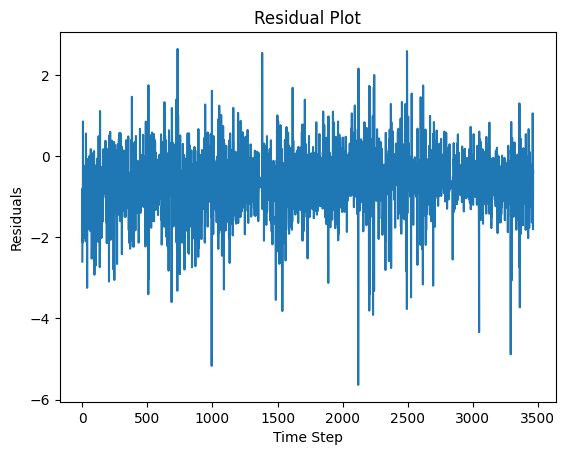

In [92]:
# prompt: plot residuals but first flatten arrays

import matplotlib.pyplot as plt
residuals = y_test.flatten() - predictions.flatten()
plt.plot(residuals)
plt.title('Residual Plot')
plt.xlabel('Time Step')
plt.ylabel('Residuals')
plt.show()


In [93]:
# prompt: plot residuals for training data

import matplotlib.pyplot as plt
residuals_train = y_train - y_train_pred.flatten()
plt.plot(residuals_train)
plt.title('Residual Plot for Training Data')
plt.xlabel('Time Step')
plt.ylabel('Residuals')
plt.show()


ValueError: operands could not be broadcast together with shapes (13918,) (11918,) 

In [82]:
# prompt: evaluate the model

loss, mae = model.evaluate(X_test, y_test)

print(f"Test Loss: {loss}")
print(f"Test MAE: {mae}")


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9669 - mae: 0.9669
Test Loss: 0.930579662322998
Test MAE: 0.930579662322998
